In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
#import torch
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import fnmatch
import matplotlib.pyplot as plt
import scipy.fftpack
from torchsummary import summary

In [2]:
import moco.loader
import moco.builder
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

In [2]:
class BlockLSTM(nn.Module):
    def __init__(self, time_steps, num_variables, lstm_hs=256, hidden_size=256,dropout=0.8, attention=True):
        super(BlockLSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_variables
        self.lstm = nn.LSTM(input_size=time_steps, hidden_size=lstm_hs, num_layers=num_variables)
        self.fc = nn.Linear(hidden_size, 20)
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, x):
        # input is of the form (batch_size, num_variables, time_steps), e.g. (128, 1, 512)
        # lstm layer is of the form (num_variables, batch_size, time_steps)
        x = torch.transpose(x,0,1)
        h0 = torch.zeros(self.num_layers , x.size(1), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers , x.size(1), self.hidden_size).to(device)
        y,_ = self.lstm(x,(h0, c0))
        # dropout layer input shape:
        y = self.fc(y[-1,:, :])
        y = self.dropout(y)
        # output shape is of the form ()
        return y

In [21]:
net1=BlockLSTM(time_steps=176,num_variables=1)
print(net1)

BlockLSTM(
  (lstm): LSTM(176, 256)
  (fc): Linear(in_features=256, out_features=20, bias=True)
  (dropout): Dropout(p=0.8, inplace=False)
)


In [28]:
net2=BlockFCN(time_steps=176)
print(net)

LSTMFCN(
  (lstm_block): BlockLSTM(
    (lstm): LSTM(176, 256)
    (fc): Linear(in_features=256, out_features=20, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
  (fcn_block): BlockFCN(
    (conv): Conv1d(1, 128, kernel_size=(8,), stride=(1,))
    (batch_norm): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
    (batch_norm2): BatchNorm1d(256, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
    (batch_norm3): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (global_pooling): AvgPool1d(kernel_size=(90,), stride=(90,), padding=(0,))
    (fc): Linear(in_features=128, out_features=20, bias=True)
  )
  (softmax): Softmax(dim=None)
)


In [23]:
class BlockFCN(nn.Module):
    def __init__(self, time_steps,channels=[1, 128, 256, 128], kernels=[8, 5, 3], mom=0.99, eps=0.001):
        super(BlockFCN,self).__init__()
        self.conv = nn.Conv1d(channels[0], channels[1], kernels[0])
        self.batch_norm = nn.BatchNorm1d(num_features=channels[1], eps=eps, momentum=mom)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(channels[1], channels[2], kernels[1])
        self.batch_norm2 = nn.BatchNorm1d(num_features=channels[2], eps=eps, momentum=mom)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(channels[2], channels[3], kernels[2])
        self.batch_norm3 = nn.BatchNorm1d(num_features=channels[3], eps=eps, momentum=mom)
        self.relu3 = nn.ReLU()   
        output_size = time_steps - sum(kernels) + len(kernels)
        self.global_pooling = nn.AvgPool1d(kernel_size=90)
        self.fc = nn.Linear(channels[3], 20)
    def forward(self, x):
        # input (batch_size, num_variables, time_steps), e.g. (128, 1, 512)
        #x = torch.transpose(x,0,1)
        x = self.conv(x)
        # input (batch_size, out_channel, L_out)
        x = self.batch_norm(x)
        # same shape as input
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.relu3(x)
        y = self.global_pooling(x)
        y = self.fc(y[:,:,-1])
        return y

In [26]:
class LSTMFCN(nn.Module):
    def __init__(self,time_steps, num_variables):
        super(LSTMFCN,self).__init__()
        self.lstm_block = BlockLSTM(time_steps, num_variables)
        self.fcn_block = BlockFCN(time_steps)
        self.softmax = nn.Softmax()
    def forward(self, x):
        # input is (batch_size, time_steps), it has to be (batch_size, 1, time_steps)
        # pass input through LSTM block
        outputs1 = self.lstm_block(x)
        # pass input through FCN block
        outputs2 = self.fcn_block(x)
        # concatenate blocks output
        #print(outputs1.size(0),outputs2.size(0))
        x = torch.cat([outputs1, outputs2],dim=1)
        #print(outputs1.size(0),outputs2.size(0),x.size(0))
        # pass through Softmax activation
        y = self.softmax(x)
        return y

In [11]:
a=pd.read_csv('../data/Adiac_TRAIN')
X_train,Y_train=np.array(a.iloc[:,1:]),np.array(a.iloc[:,1])
cuda = torch.device('cuda')
X_tensor = torch.tensor(X_train, dtype=torch.float32,requires_grad=True)
y_tensor = torch.tensor(Y_train, dtype=torch.long)
train_ds = data_utils.TensorDataset(X_tensor, y_tensor)
train_dl = DataLoader(train_ds, batch_size=30, shuffle=False)

In [12]:
len(X_train[0])

176

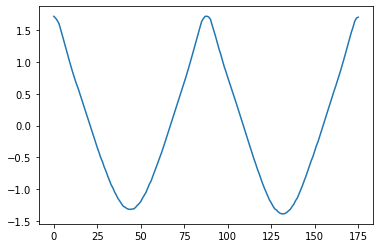

In [27]:
net2=BlockFCN(time_steps=176)
net1=BlockLSTM(time_steps=176,num_variables=1)
net=LSTMFCN(time_steps=176, num_variables=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(LSTMFCN(time_steps=len(X_train[0]), num_variables=2).parameters(), lr=0.001, momentum=0.9)
epoches=10

In [14]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train_dl):
            # get the inputs; data is a list of [inputs, labels]
            running_loss = 0.0
            inputs, labels = data
            inputs = inputs.unsqueeze(1)
            optimizer.zero_grad()
            #outputs1 =net1(inputs)
            #outputs2 =net2(inputs)
            #print(inputs.size(),outputs1.size(),outputs2.size())
            outputs=net(inputs)
            #print(outputs1.size(),outputs2.size())
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [15]:
b=pd.read_csv('../data/Adiac_TEST')
X_test,Y_test=np.array(b.iloc[:,1:]),np.array(b.iloc[:,0])
cuda = torch.device('cuda')
X_tensor = torch.tensor(X_test, dtype=torch.float32,requires_grad=True)
y_tensor = torch.tensor(Y_test, dtype=torch.long)
test_ds = data_utils.TensorDataset(X_tensor, y_tensor)
test_dl = DataLoader(train_ds, batch_size=64, shuffle=False)

In [ ]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train_dl,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        print(len(labels))
        inputs=inputs.unsqueeze(1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs =net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0 

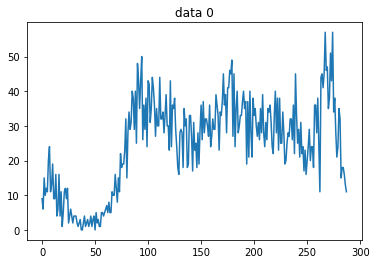

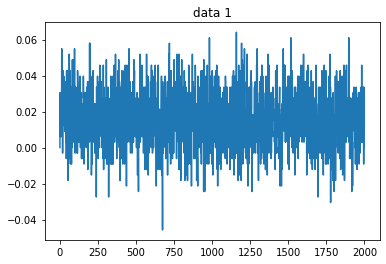

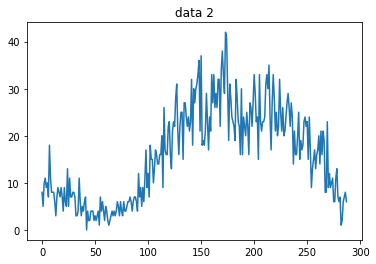

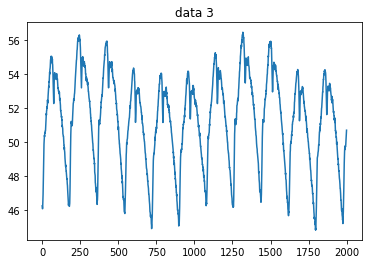

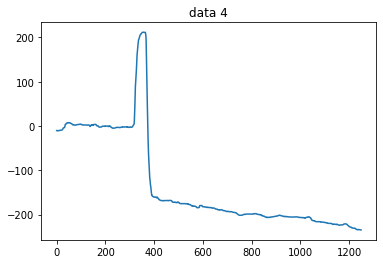

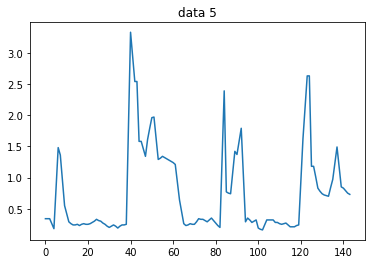

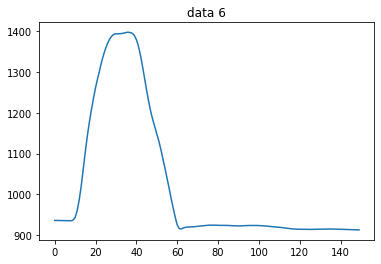

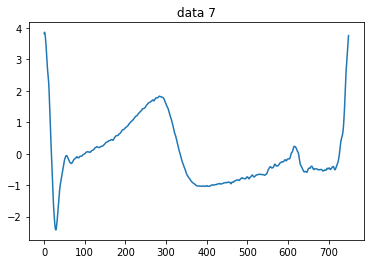

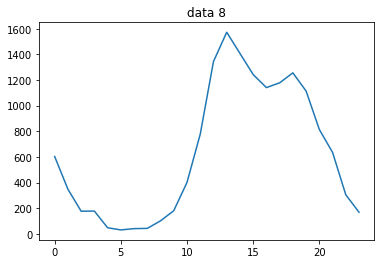

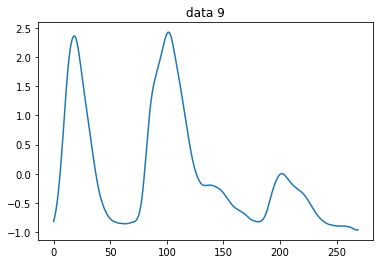

In [6]:
basepath = '../data'
i=0
for filename in os.listdir(basepath):
     if fnmatch.fnmatch(filename, '*TRAIN'):
        training_path=basepath+'/'+filename
        c=pd.read_csv(training_path)
        X_train=np.array(c.iloc[:,1:])
        
        plt.figure()
        plt.plot(X_train[1])
        plt.title('data {}'.format(i))
        
        i=i+1
        if i==10:
            break

In [11]:
def slice_data(data_x, data_y, slice_ratio): 
    #return the sliced dataset
    if slice_ratio == 1:
        return data_x, data_y
    n = data_x.shape[0]
    length = data_x.shape[1]
    length_sliced = int(length * slice_ratio)
   
    increase_num = length - length_sliced + 1 #if increase_num =5, it means one ori becomes 5 new instances.
    n_sliced = n * increase_num
    #print "*increase num", increase_num
    #print "*new length", n_sliced, "orginal len", n

    new_x = np.zeros((n_sliced, length_sliced))
    new_y = np.zeros((n_sliced))
    for i in range(n):
        for j in range(increase_num):
            new_x[i * increase_num + j, :] = data_x[i,j : j + length_sliced]
            new_y[i * increase_num + j] = np.int_(data_y[i].astype(np.float32))
    return new_x, new_y

In [51]:
def fft(data_x):
    new_x=scipy.fftpack.fft(data_x)
    #new_y=data_y
    return new_x

In [7]:
def flip(data_x,data_y):
    new_x=-data_x
    new_y=data_y
    return new_x,new_y

In [49]:
def noise(data_x):
    noise = np.random.normal(0,1,len(data_x))
    data_x=data_x+noise
    return data_x

In [46]:
i=0
noise = np.random.normal(0,1,len(X_train[1]))
for data in X_train[1]:
    print(data)
    data=data+noise
    print(data)
    i=i+1
    if i==3:
        break

1.7223419999999998
[ 0.96298736  2.39367977  1.46450815  2.64412672  2.77638673  0.77284692
  0.55459044  1.57396212  1.69909121  2.40381847  1.49529487  2.27775126
  1.06601953  2.04812008  2.50272917  1.27300064  2.29596623  1.24145546
 -0.59879755  1.24148919  1.53997852  0.3752015   1.02952296  2.67411124
  1.95906398  1.75328249  1.97891086  2.43072768  3.19031463  2.34570523
  1.53296443  1.76992981  3.49482449  2.09060364  2.80539684  2.33175126
  2.50292652  1.50320528  2.52505584  2.67656412  1.798046    2.40037545
  1.74190097  2.47006089  2.34784291  2.50793004  1.58996475  1.47420979
  2.17266324  1.54416226  0.73892206  2.05543112  1.83632582 -0.30565674
  1.47557451  0.33422911  1.67615222  2.45109501  0.76464832  2.12864389
  0.42008971  4.17327973  1.17477298  0.67481412  0.5602997   2.17855277
  0.71706428  2.21298492  1.09919453  0.41808608  3.17317927  0.12331245
 -0.39202131  1.1881927   3.02261329  1.22800139  3.00804191  0.57056013
  0.62422063  1.57290372  3.2918

In [7]:
class Moco(nn.Module):
    def __init__(self, base_encoder, dim=128, K=65536, m=0.999, T=0.07, mlp=False):
        super(MoCo, self).__init__()
        self.K = K
        self.m = m
        self.T = T
        self.encoder_q = base_encoder(num_classes=dim)
        self.encoder_k = base_encoder(num_classes=dim)
        
        if mlp:  # hack: brute-force replacement
            dim_mlp = self.encoder_q.fc.weight.shape[1]
            self.encoder_q.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_q.fc)
            self.encoder_k.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_k.fc)

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient
        
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))
        
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)
        
    def _batch_shuffle_ddp(self, x):
        """
        Batch shuffle, for making use of BatchNorm.
        *** Only support DistributedDataParallel (DDP) model. ***
        """
        batch_size_this = x.shape[0]
        x_gather = concat_all_gather(x)
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # random shuffle index
        idx_shuffle = torch.randperm(batch_size_all).cuda()

        # broadcast to all gpus
        torch.distributed.broadcast(idx_shuffle, src=0)

        # index for restoring
        idx_unshuffle = torch.argsort(idx_shuffle)

        # shuffled index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_shuffle.view(num_gpus, -1)[gpu_idx]

        return x_gather[idx_this], idx_unshuffle
    
    def _batch_unshuffle_ddp(self, x, idx_unshuffle):
        """
        Undo batch shuffle.
        *** Only support DistributedDataParallel (DDP) model. ***
        """
        # gather from all gpus
        batch_size_this = x.shape[0]
        x_gather = concat_all_gather(x)
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # restored index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_unshuffle.view(num_gpus, -1)[gpu_idx]

        return x_gather[idx_this]
    
    def forward(self, im_q, im_k):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            logits, targets
        """

        # compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)

        # compute key features
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()  # update the key encoder

            # shuffle for making use of BN
            im_k, idx_unshuffle = self._batch_shuffle_ddp(im_k)

            k = self.encoder_k(im_k)  # keys: NxC
            k = nn.functional.normalize(k, dim=1)

            # undo shuffle
            k = self._batch_unshuffle_ddp(k, idx_unshuffle)

        # compute logits
        # Einstein sum is more intuitive
        # positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

        # dequeue and enqueue
        self._dequeue_and_enqueue(k)

        return logits, labels

In [8]:
def train(train_loader,model,criterion,optimizer,epoch,args):
    for epoch in range(2):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                running_loss = 0.0
                inputs, labels = data
                inputs = inputs.unsqueeze(1)
                optimizer.zero_grad()
                #outputs1 =net1(inputs)
                #outputs2 =net2(inputs)
                #print(inputs.size(),outputs1.size(),outputs2.size())
                outputs=net(inputs)
                #print(outputs1.size(),outputs2.size())
                loss = criterion(outputs,labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

In [12]:
model = moco.builder.MoCo(net, dim=128, K=65536, m=0.999, T=0.07, mlp=False)

TypeError: forward() got an unexpected keyword argument 'time_steps'